In [17]:
# -------------------------------------------
# Imports & notebook housekeeping
# -------------------------------------------

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------------------------
from datetime import datetime
import itertools
import calendar as cal                   # weekday / month names
import scipy.stats as stats              # normality, skew, etc.

# -------------------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import lightgbm as lgb                   # gradient boosting (fast baseline)
import xgboost as xgb                    # alternative GBM
# import prophet                          # uncomment if you want fbprophet
import statsmodels.api as sm            # ARIMA, ETS, SARIMAX, etc.


# -------------------------------------------
import plotly.express as px              # interactive EDA
import plotly.graph_objects as go

# -------------------------------------------
# Reproducibility
SEED = 42
np.random.seed(SEED)

# -------------------------------------------
# Nice-to-have settings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")          # comment out if you prefer default
# # keep this line by itself if you want explicit inline plotting
# %matplotlib inline

# -------------------------------------------
# Wider, higher-res plots for Matplotlib
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["figure.dpi"] = 110

In [18]:
# -------------------------------------------
# File locations
# -------------------------------------------]

DATA_PATH = Path("data")            # adjust if our folder is elsewhere

train_path      = DATA_PATH / "train.csv"
calendar_path   = DATA_PATH / "calendar_events.csv"
submission_path = DATA_PATH / "forecast_submission.csv"

In [22]:
# -------------------------------------------
# Load the data
# -------------------------------------------

# parse_dates converts the 'date' string into pandas.Timestamp
train_df    = pd.read_csv(train_path,    parse_dates=["date"])
calendar_df = pd.read_csv(calendar_path, parse_dates=["date"])
test_df     = pd.read_csv(submission_path)   # 'id' already encodes date

# quick sanity check
print("Train shape     :", train_df.shape)
print("Calendar shape  :", calendar_df.shape)
print("Forecast shape  :", test_df.shape)

display(train_df)
display(calendar_df)
display(test_df)

Train shape     : (18766, 4)
Calendar shape  : (162, 2)
Forecast shape  : (1012, 2)


,store_id,store_name,date,revenue
0,0,All Stores,2011-01-29,204126.52
1,0,All Stores,2011-01-30,197426.42
2,0,All Stores,2011-01-31,144267.27
3,0,All Stores,2011-02-01,151903.00
4,0,All Stores,2011-02-02,117399.88
...,...,...,...,...
18761,10,Wisconsin – Badger Crossing,2015-09-26,25689.55
18762,10,Wisconsin – Badger Crossing,2015-09-27,26557.53
18763,10,Wisconsin – Badger Crossing,2015-09-28,19067.53
18764,10,Wisconsin – Badger Crossing,2015-09-29,16467.95


,date,event
0,2011-02-06,SuperBowl
1,2011-02-14,ValentinesDay
2,2011-02-21,PresidentsDay
3,2011-03-09,LentStart
4,2011-03-16,LentWeek2
...,...,...
157,2016-05-08,Mother's day
158,2016-05-30,MemorialDay
159,2016-06-02,NBAFinalsStart
160,2016-06-07,Ramadan starts


,id,prediction
0,0_20151001,0
1,0_20151002,0
2,0_20151003,0
3,0_20151004,0
4,0_20151005,0
...,...,...
1007,10_20151227,0
1008,10_20151228,0
1009,10_20151229,0
1010,10_20151230,0


In [23]:
# Helper function to make a Kaggle submission file
def make_submission(preds, template_path="data/forecast_submission.csv",
                    out_path="my_submission.csv"):
    """
    Put predictions into exact Kaggle format and save the CSV.
    Assumes `preds` are in the **same order** as rows in the template.
    """
    template = pd.read_csv(template_path)
    if len(preds) != len(template):
        raise ValueError(f"Row-count mismatch: {len(preds)=}, "
                         f"{len(template)=}")
    sub = template.copy()
    sub["prediction"] = np.asarray(preds).ravel()
    sub.to_csv(out_path, index=False)
    print(f"✅  Saved {out_path}  ({len(sub):,} rows)")
    return sub

### Data exploration

b####  Daily revenue lines, faceted by store_id

**Take-aways**

Trend: every store shows a roughly monotonic rise—good evidence of macro growth.

Weekly pulses: the saw-tooth pattern hints at a strong weekday/weekend cycle.

Data gaps/outliers: vertical drops to (almost) zero on identical dates across stores—likely system outages or missing-data days; we should flag or impute them.

Scale differences: store 0 dwarfs the others, confirming it’s the aggregate series (see Q&A at bottom).


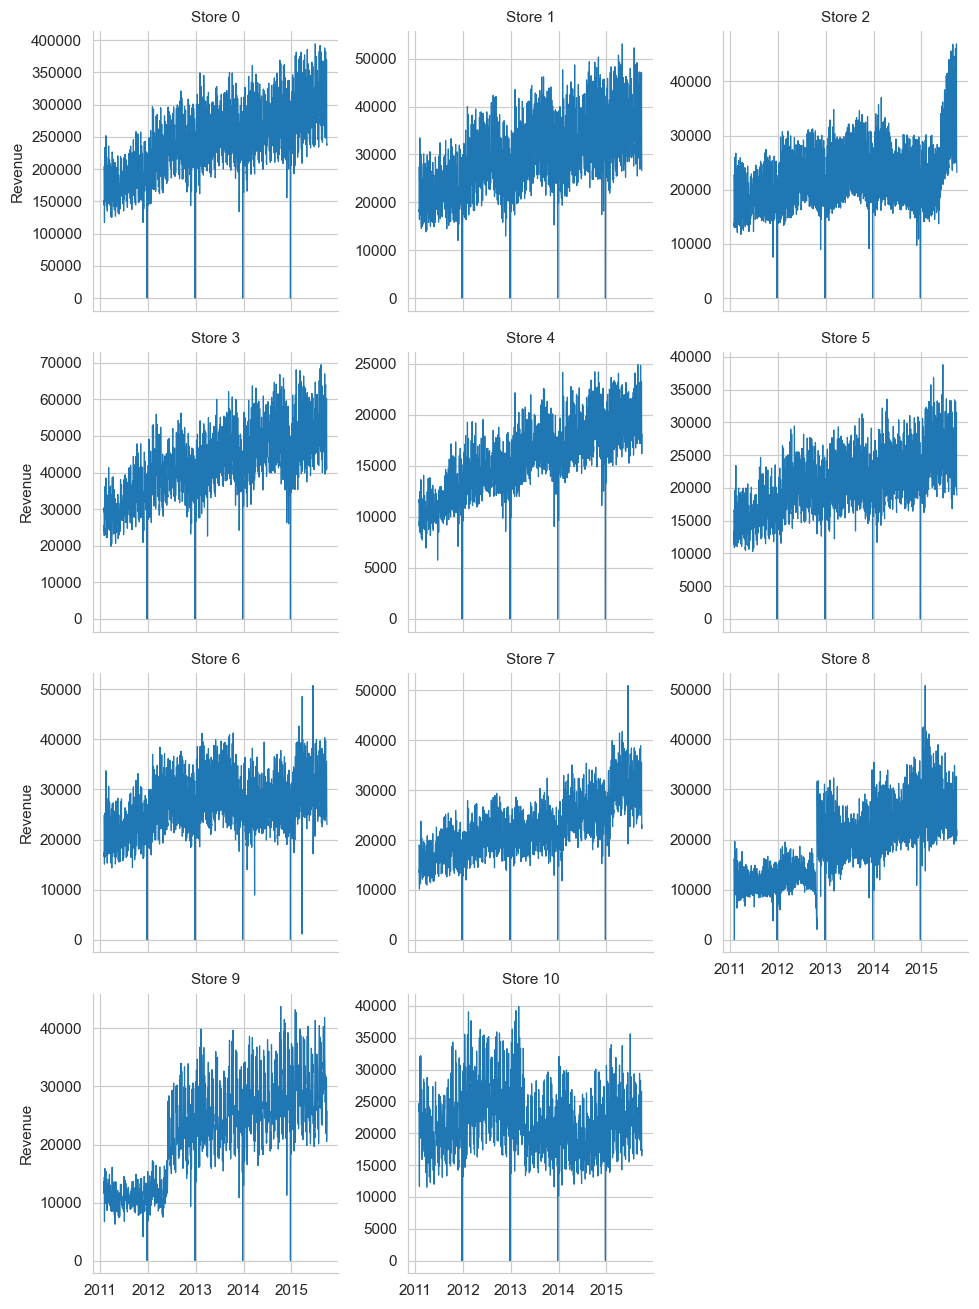

In [24]:
# -----------------------------------------------------------
# Daily revenue lines, faceted by store_id
# -----------------------------------------------------------

g = sns.FacetGrid(
    data=train_df,
    col="store_id",
    col_wrap=3,        # 3 columns per row
    height=3,
    sharey=False
)
g.map_dataframe(sns.lineplot, x="date", y="revenue", lw=0.8)
g.set_titles("Store {col_name}")
g.set_axis_labels("", "Revenue")
plt.tight_layout()
plt.show()

#### 30-day moving average vs. raw daily series (example: store 0)

**Take-aways**

* needs to expect all the stores to be present, not just store 0

Structural trend: 30-day MA climbs from ~180 k → 310 k, confirming long-term growth.

Seasonal bumps: gentle yearly waves (likely Q4 holiday lift).

Extreme troughs: the periodic near-zero spikes match the outages seen above—helps decide outlier handling.


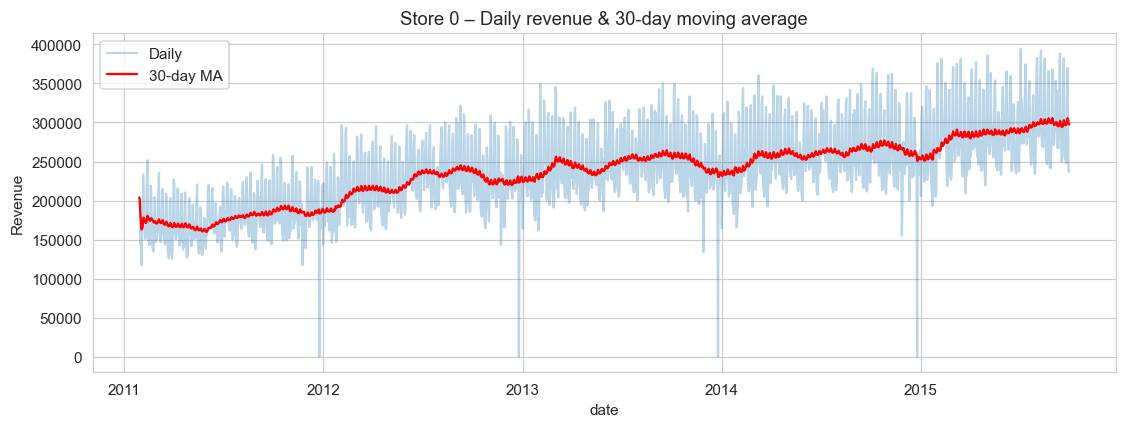

In [35]:
# -----------------------------------------------------------
# Moving average overlay for the "all-stores" series (store_id 0)
# -----------------------------------------------------------
store0 = (
    train_df.loc[train_df.store_id == 0]
            .sort_values("date")
            .assign(ma_30=lambda d: d.revenue.rolling(30, min_periods=1).mean())
)

plt.figure(figsize=(12,4))
sns.lineplot(data=store0, x="date", y="revenue", alpha=0.3, label="Daily")
sns.lineplot(data=store0, x="date", y="ma_30",        color="red", label="30-day MA")
plt.title("Store 0 – Daily revenue & 30-day moving average")
plt.ylabel("Revenue")
plt.show()

#### Weekday pattern (all stores combined)

**Take-aways**

Weekend premium: Sat/Sun medians roughly 25 % higher than mid-week.

Friday build-up: Friday sits between weekdays and weekends—useful for lag features.

Monday rebound: Monday median still higher than Tue–Thu—interesting after-weekend catch-up.

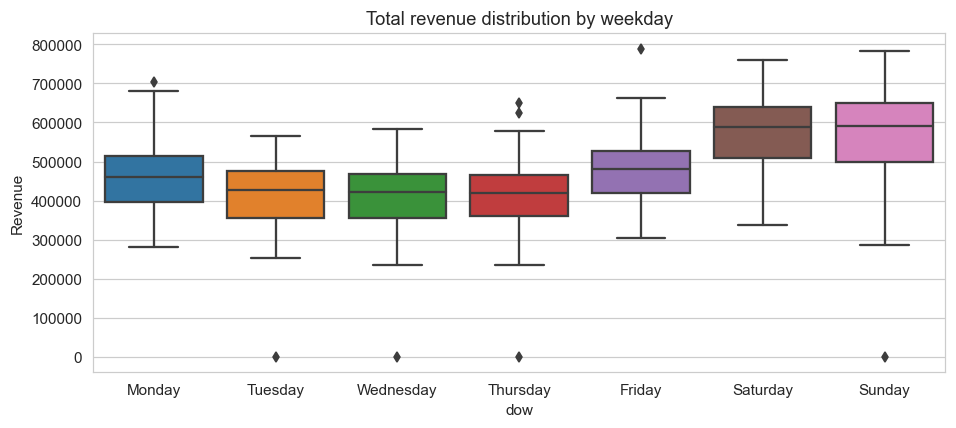

In [26]:
# -----------------------------------------------------------
# Box-plot by day-of-week
# -----------------------------------------------------------
weekday_df = (
    train_df.assign(dow=train_df.date.dt.day_name())
            .groupby(["dow", "date"]).revenue.sum().reset_index()  # total across stores
)
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

plt.figure(figsize=(10,4))
sns.boxplot(data=weekday_df, x="dow", y="revenue", order=order)
plt.title("Total revenue distribution by weekday")
plt.ylabel("Revenue")
plt.show()

#### Month-over-month total revenue (stacked by store)

**Take-aways**

Growth slope: aggregate monthly revenue ~doubles over 5 years, confirms non-stationarity.

Store mix stability: colour bands keep their thickness ~constant → stores grow proportionally; no single store overtakes others (apart from store 0’s built-in dominance).

Holiday peak: one large spike Q4-2013; cross-check with calendar_events.


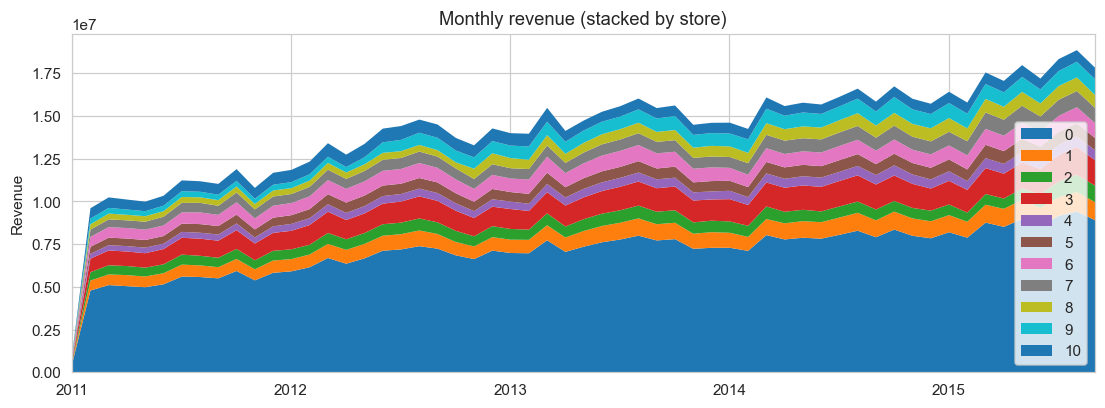

In [29]:
# -----------------------------------------------------------
# Monthly totals pivoted wide → stacked area chart
# -----------------------------------------------------------
monthly_totals = (
    train_df.assign(ym=train_df.date.dt.to_period("M"))
            .groupby(["ym", "store_id"]).revenue.sum()
            .unstack("store_id")
            .rename_axis(index=None, columns=None)
)
monthly_totals.index = monthly_totals.index.to_timestamp()  # Period → Timestamp

monthly_totals.plot.area(figsize=(12,4), stacked=True, linewidth=0)
plt.title("Monthly revenue (stacked by store)")
plt.ylabel("Revenue")
plt.show()

#### Holiday / special-event impact scatter

**Take-aways**

* not to understandable plot needs to be addapted

Positive lift: most coloured markers sit high above the daily baseline—events ≈ sales boosters.

Event variance: some events cluster lower, meaning not every holiday helps (e.g., minor state holidays).

Missing labels: a few natural peaks lack an event tag—maybe promo periods worth creating custom flags for (e.g., “Back-to-School” week).


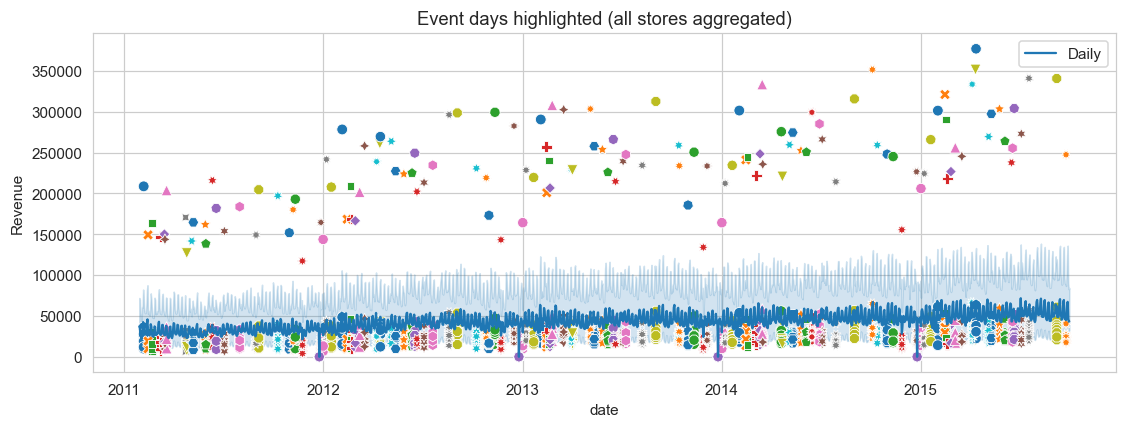

In [30]:
# -----------------------------------------------------------
# Overlay known events on the daily series
# -----------------------------------------------------------
# Merge event labels onto train_df
events = calendar_df.rename(columns={"event": "event_name"})
tmp = train_df.merge(events, on="date", how="left")

plt.figure(figsize=(12,4))
sns.lineplot(data=tmp, x="date", y="revenue", label="Daily")
sns.scatterplot(
    data=tmp[tmp.event_name.notna()],
    x="date", y="revenue",
    hue="event_name", style="event_name",
    palette="tab10", legend=False, s=50
)
plt.title("Event days highlighted (all stores aggregated)")
plt.ylabel("Revenue")
plt.show()

### Uplift bar chart – How much does each event lift sales overall?

**take aways:**
- Only a handful of holidays generate > 5 k lift in the aggregate series.
→ worth creating explicit binary features (is_superbowl, is_easter_week, …).
- Religious holidays (Easter variants, Eid, Ramadan) and U.S. social events (Super Bowl, Father’s Day) dominate; Independence Day is not top-15—interesting anomaly to double-check.
- Since values are absolute dollar, the effect on individual stores will be smaller; we need a per-store view.

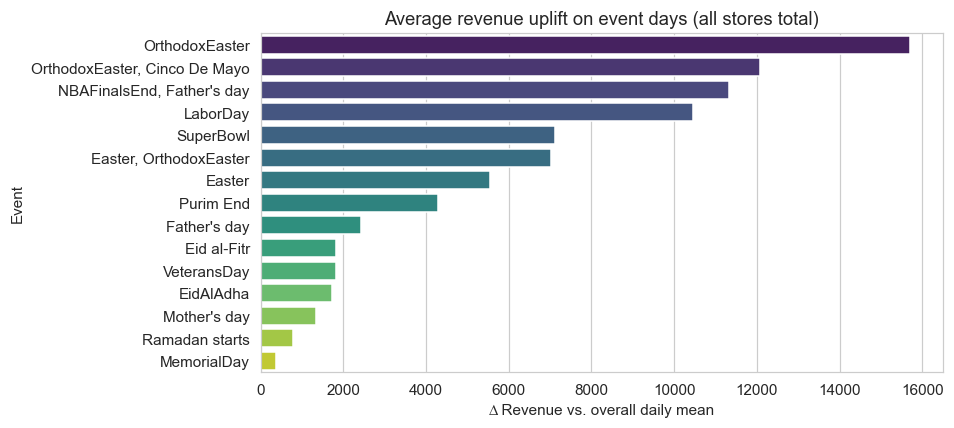

In [36]:
# -----------------------------------------------------------
# 1. Compute uplift = event_day_mean - non_event_mean
# -----------------------------------------------------------
df = train_df.merge(calendar_df, on="date", how="left")

overall_mean = df["revenue"].mean()

uplift = (
    df.groupby("event")["revenue"]
      .mean()
      .sub(overall_mean)             # absolute difference
      .sort_values(ascending=False)
      .head(15)                      # top 15 events
)

# -----------------------------------------------------------
# 2. Plot
# -----------------------------------------------------------
plt.figure(figsize=(8,4))
sns.barplot(y=uplift.index, x=uplift.values, palette="viridis")
plt.title("Average revenue uplift on event days (all stores total)")
plt.xlabel("∆ Revenue vs. overall daily mean")
plt.ylabel("Event")
plt.show()

### “Per-store heat-map” – Which stores benefit from which events?

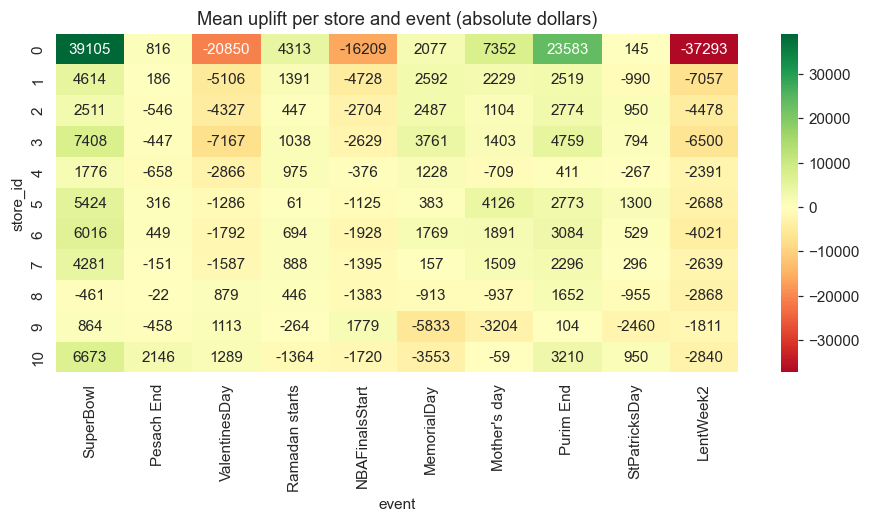

In [37]:
# -----------------------------------------------------------
# 1. Build a pivot table: store_id × event_name
# -----------------------------------------------------------
pivot = (
    df.groupby(["store_id", "event"])["revenue"]
      .mean()
      .unstack("event")                          # columns = events
      .sub(df.groupby("store_id")["revenue"].mean(), axis=0)  # centre per-store
)

# -----------------------------------------------------------
# 2. Keep most frequent events to avoid giant table
# -----------------------------------------------------------
top_events = (
    calendar_df["event"]
      .value_counts()
      .head(10)                # pick 10 busiest holidays
      .index
)
pivot = pivot[top_events]

# -----------------------------------------------------------
# 3. Plot heat-map
# -----------------------------------------------------------
plt.figure(figsize=(10,4))
sns.heatmap(pivot, cmap="RdYlGn", center=0, annot=True, fmt=".0f")
plt.title("Mean uplift per store and event (absolute dollars)")
plt.ylabel("store_id")
plt.show()

#### Simple outlier screen (per-store whiskers)

**Take-aways**


Scale heterogeneity: store 0 median ≈ 250 k, others 20–60 k → models need either per-store scaling or loss weighting.

Outliers: whiskers extend to zero for all stores—same outage issue; high-end outliers <2 % of points → decide whether to leave or cap.

Skew: slight positive skew for most stores, so a log1p transform could help tree-based models.


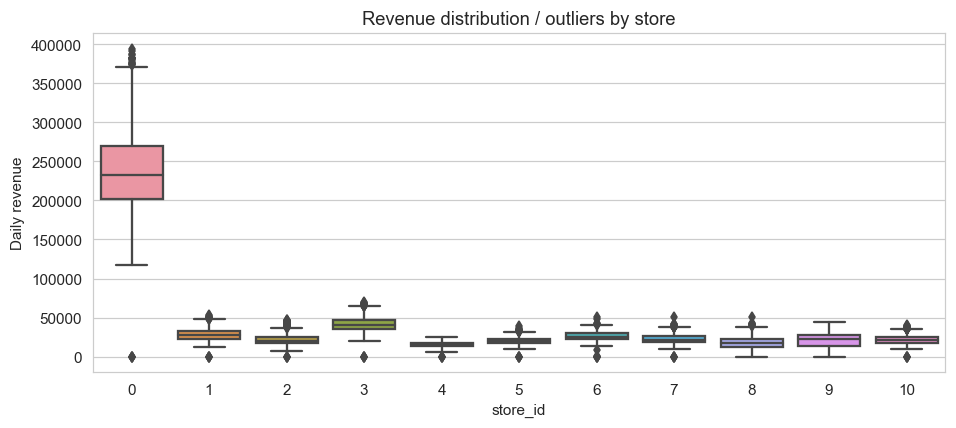

In [31]:
# -----------------------------------------------------------
# Revenue box-plot per store for outlier detection
# -----------------------------------------------------------
plt.figure(figsize=(10,4))
sns.boxplot(data=train_df, x="store_id", y="revenue")
plt.title("Revenue distribution / outliers by store")
plt.ylabel("Daily revenue")
plt.show()